> edit

Time-series transformer generative adversarial networks(Srinivasan, Padmanaba and Knottenbelt, William J)

Chickenpox The UCI Hungarian Chickenpox Cases dataset [40, 16] consists of records of chickenpox cases weekly in 20 counties in Hungary. This dataset represents a realistic situation where generative models be trained on small amounts of data and then generate synthetic samples to train other models. (20 features and 521 rows.)

# import

In [1]:
import itstgcn 
import torch
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
import random

In [4]:
class Eval_csy:
    def __init__(self,learner,train_dataset):
        self.learner = learner
        # self.learner.model.eval()
        try:self.learner.model.eval()
        except:pass
        self.train_dataset = train_dataset
        self.lags = self.learner.lags
        rslt_tr = self.learner(self.train_dataset) 
        self.X_tr = rslt_tr['X']
        self.y_tr = rslt_tr['y']
        self.f_tr = torch.concat([self.train_dataset[0].x.T,self.y_tr],axis=0).float()
        self.yhat_tr = rslt_tr['yhat']
        self.fhat_tr = torch.concat([self.train_dataset[0].x.T,self.yhat_tr],axis=0).float()

In [5]:
import pickle
import pandas as pd

In [6]:
def load_data(fname):
    with open(fname, 'rb') as outfile:
        data_dict = pickle.load(outfile)
    return data_dict

def save_data(data_dict,fname):
    with open(fname,'wb') as outfile:
        pickle.dump(data_dict,outfile)

In [7]:
from plotnine import *

# Example

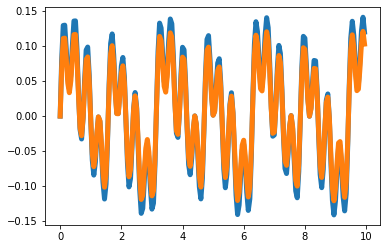

In [8]:
T = 200
t = np.arange(T)/T * 10
x = 0.1*np.sin(2*t)+0.2*np.sin(4*t)+0.1*np.sin(8*t)+0.2*np.sin(16*t)
eps_x  = np.random.normal(size=T)*0
y = x.copy()
# for i in range(2,T):
#     y[i] = 0.35*x[i-1] - 0.15*x[i-2] + 0.5*np.cos(0.5*t[i]) 
eps_y  = np.random.normal(size=T)*0
x = x*0.35
y = y*0.3
plt.plot(t,x,color='C0',lw=5)
plt.plot(t,x+eps_x,alpha=0.5,color='C0')
plt.plot(t,y,color='C1',lw=5)
plt.plot(t,y+eps_y,alpha=0.5,color='C1')
_node_ids = {'node1':0, 'node2':1}

# _FX1 = np.stack([x,y],axis=1).tolist()
_FX1 = np.stack([x+eps_x,y+eps_y],axis=1).tolist()

_edges1 = torch.tensor([[0,1],[1,0]]).tolist()

data_dict1 = {'edges':_edges1, 'node_ids':_node_ids, 'FX':_FX1}
#data_dict = itstgcn.load_data('./data/fivenodes.pkl')

save_data(data_dict1, './data/toy_example1.pkl')

data1 = pd.DataFrame({'x':x,'y':y,'xer':x,'yer':y})

save_data(data1, './data/toy_example_true1.csv')


In [9]:
data_dict1 = itstgcn.load_data('./data/toy_example1.pkl')
loader1 = itstgcn.DatasetLoader(data_dict1)

In [10]:
dataset05031 = loader1.get_dataset(lags=1)

In [11]:
# mindex05031 = itstgcn.rand_mindex(dataset05031,mrate=0)
# dataset_miss05031 = itstgcn.miss(dataset05031,mindex05031,mtype='rand')

In [12]:
mindex = [random.sample(range(0, T), int(T*0.5)),[np.array(list(range(100,120)))]]
dataset_miss05031 = itstgcn.miss(dataset05031,mindex,mtype='block')

/home/csy/Dropbox/blog/posts/GCN/itstgcn/utils.py:71: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343998658/work/torch/csrc/utils/tensor_new.cpp:245.)


In [13]:
dataset_padded_cubic05031 = itstgcn.padding(dataset_miss05031,imputation_method='cubic')

`-` 학습

In [14]:
lrnr05031 = itstgcn.StgcnLearner(dataset_padded_cubic05031)

In [15]:
lrnr05031.learn(filters=8,epoch=50)

In [16]:
df1 = itstgcn.load_data('./data/toy_example_true1.csv')

In [17]:
evtor05031 = Eval_csy(lrnr05031,dataset_padded_cubic05031)

In [18]:
lrnr05032 = itstgcn.ITStgcnLearner(dataset_padded_cubic05031)

In [19]:
lrnr05032.learn(filters=8,epoch=50)

In [20]:
evtor05032 = Eval_csy(lrnr05032,dataset_padded_cubic05031)

```python
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
# fig.suptitle('Figure 1')
ax1.plot(df1['x'][:],'--.',color='C1')
ax1.plot(evtor05031.f_tr[:,0],'--.',color='C2')
ax1.plot(evtor05031.fhat_tr[:,0],color='C3',lw=3)
ax1.set_title('STGCN')
ax2.plot(df1['y'][:],'--.',color='C1')
ax2.plot(evtor05031.fhat_tr[:,1],color='C3',lw=3)
ax2.plot(evtor05031.f_tr[:,1],'--.',color='C2')
ax2.set_title('STGCN')
ax3.plot(df1['x'][:],'--.',color='C1')
ax3.plot(evtor05032.f_tr[:,0],'--.',color='C2')
ax3.plot(evtor05032.fhat_tr[:,0],color='C4',lw=3)
ax3.set_title('ITSTGCN')
ax4.plot(df1['y'][:],'--.',color='C1')
ax4.plot(evtor05032.f_tr[:,1],'--.',color='C2')
ax4.plot(evtor05032.fhat_tr[:,1],color='C4',lw=3)
ax4.set_title('ITSTGCN')

for ax in fig.get_axes():
    ax.label_outer()
```

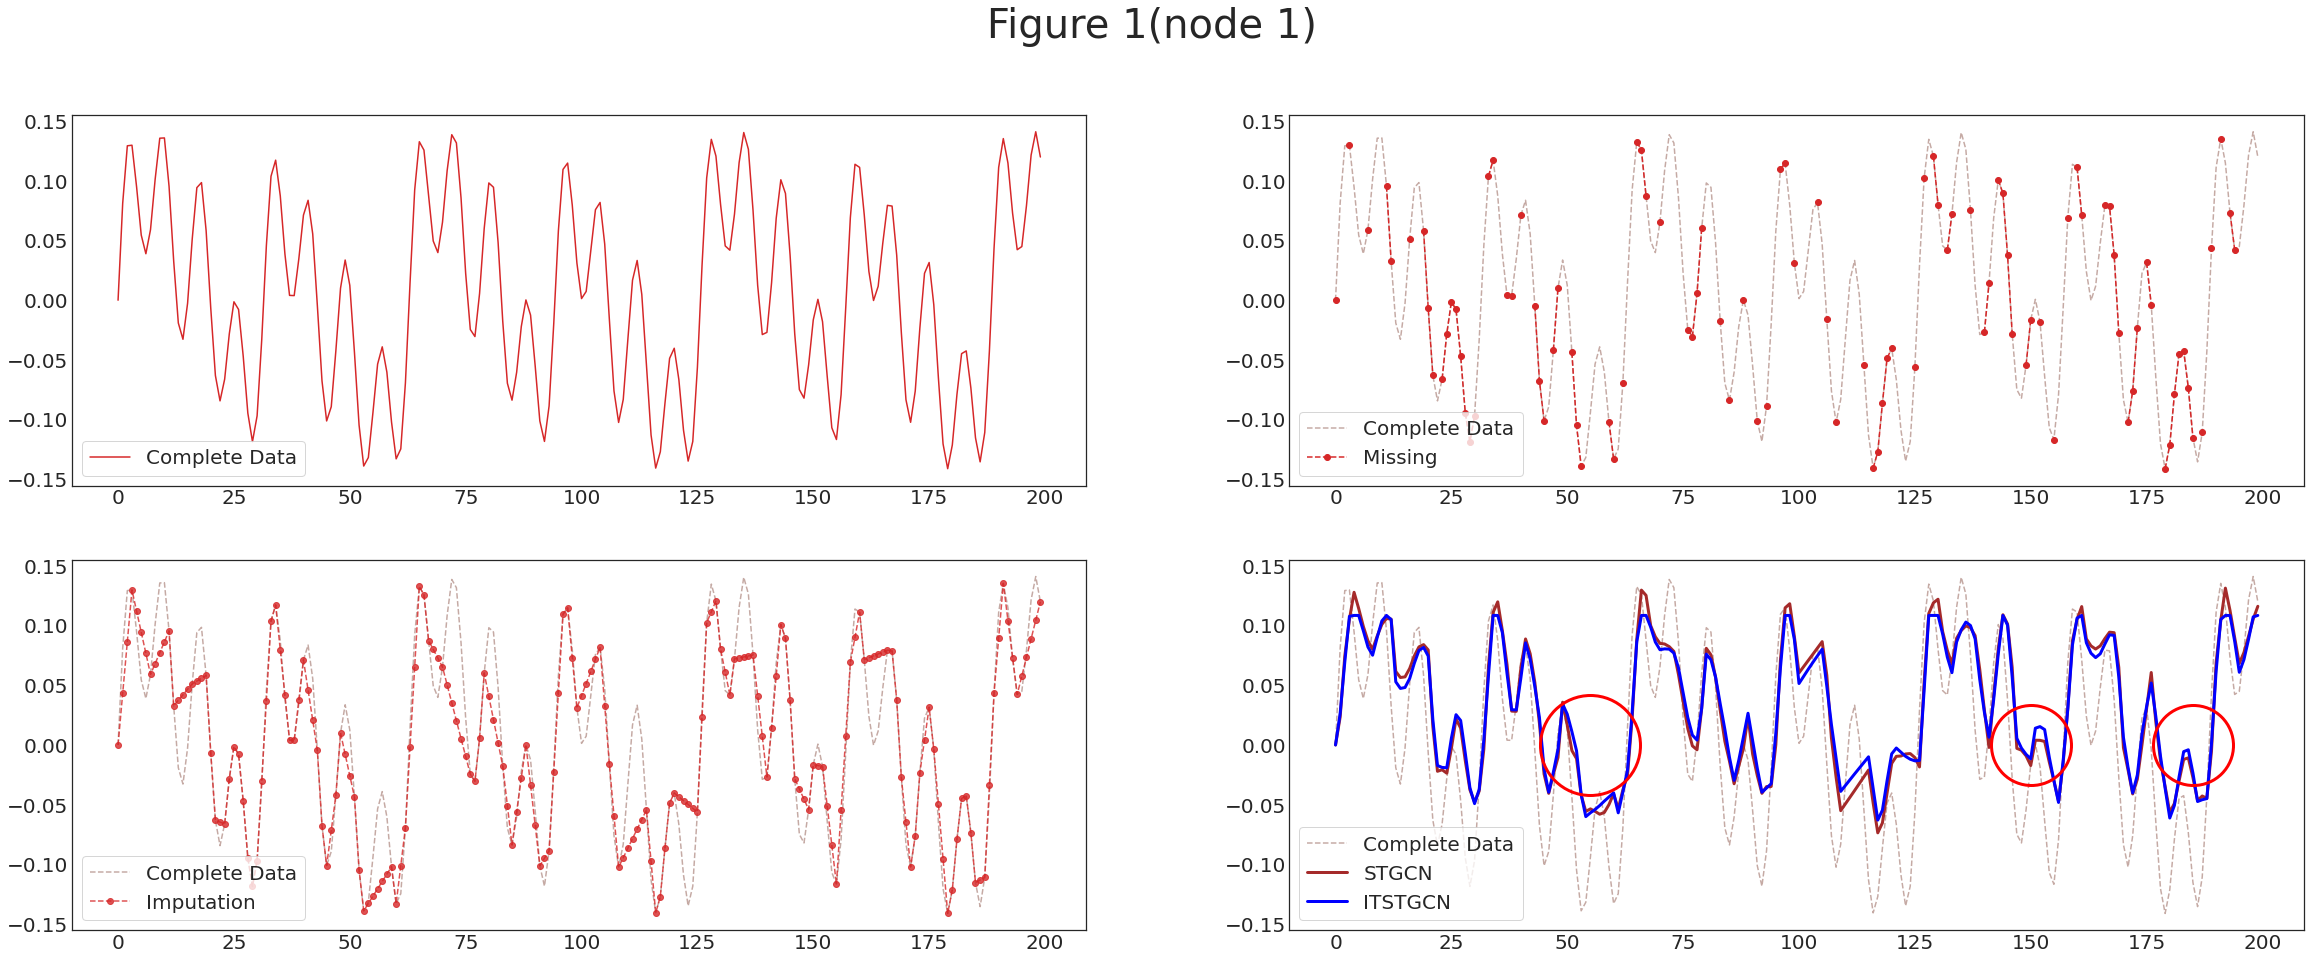

In [21]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 1)',fontsize=40)
    ax1.plot(df1['x'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax2.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss05031.features).reshape(-1,2)[:,0],'--o',color='C3',label='Missing')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax3.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor05032.f_tr[:,0],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    ax4.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor05031.fhat_tr[:,0],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor05032.fhat_tr[:,0],color='blue',lw=3,label='ITSTGCN')
    ax4.plot(55, 0, 'o', markersize=100, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.plot(150, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.plot(185, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

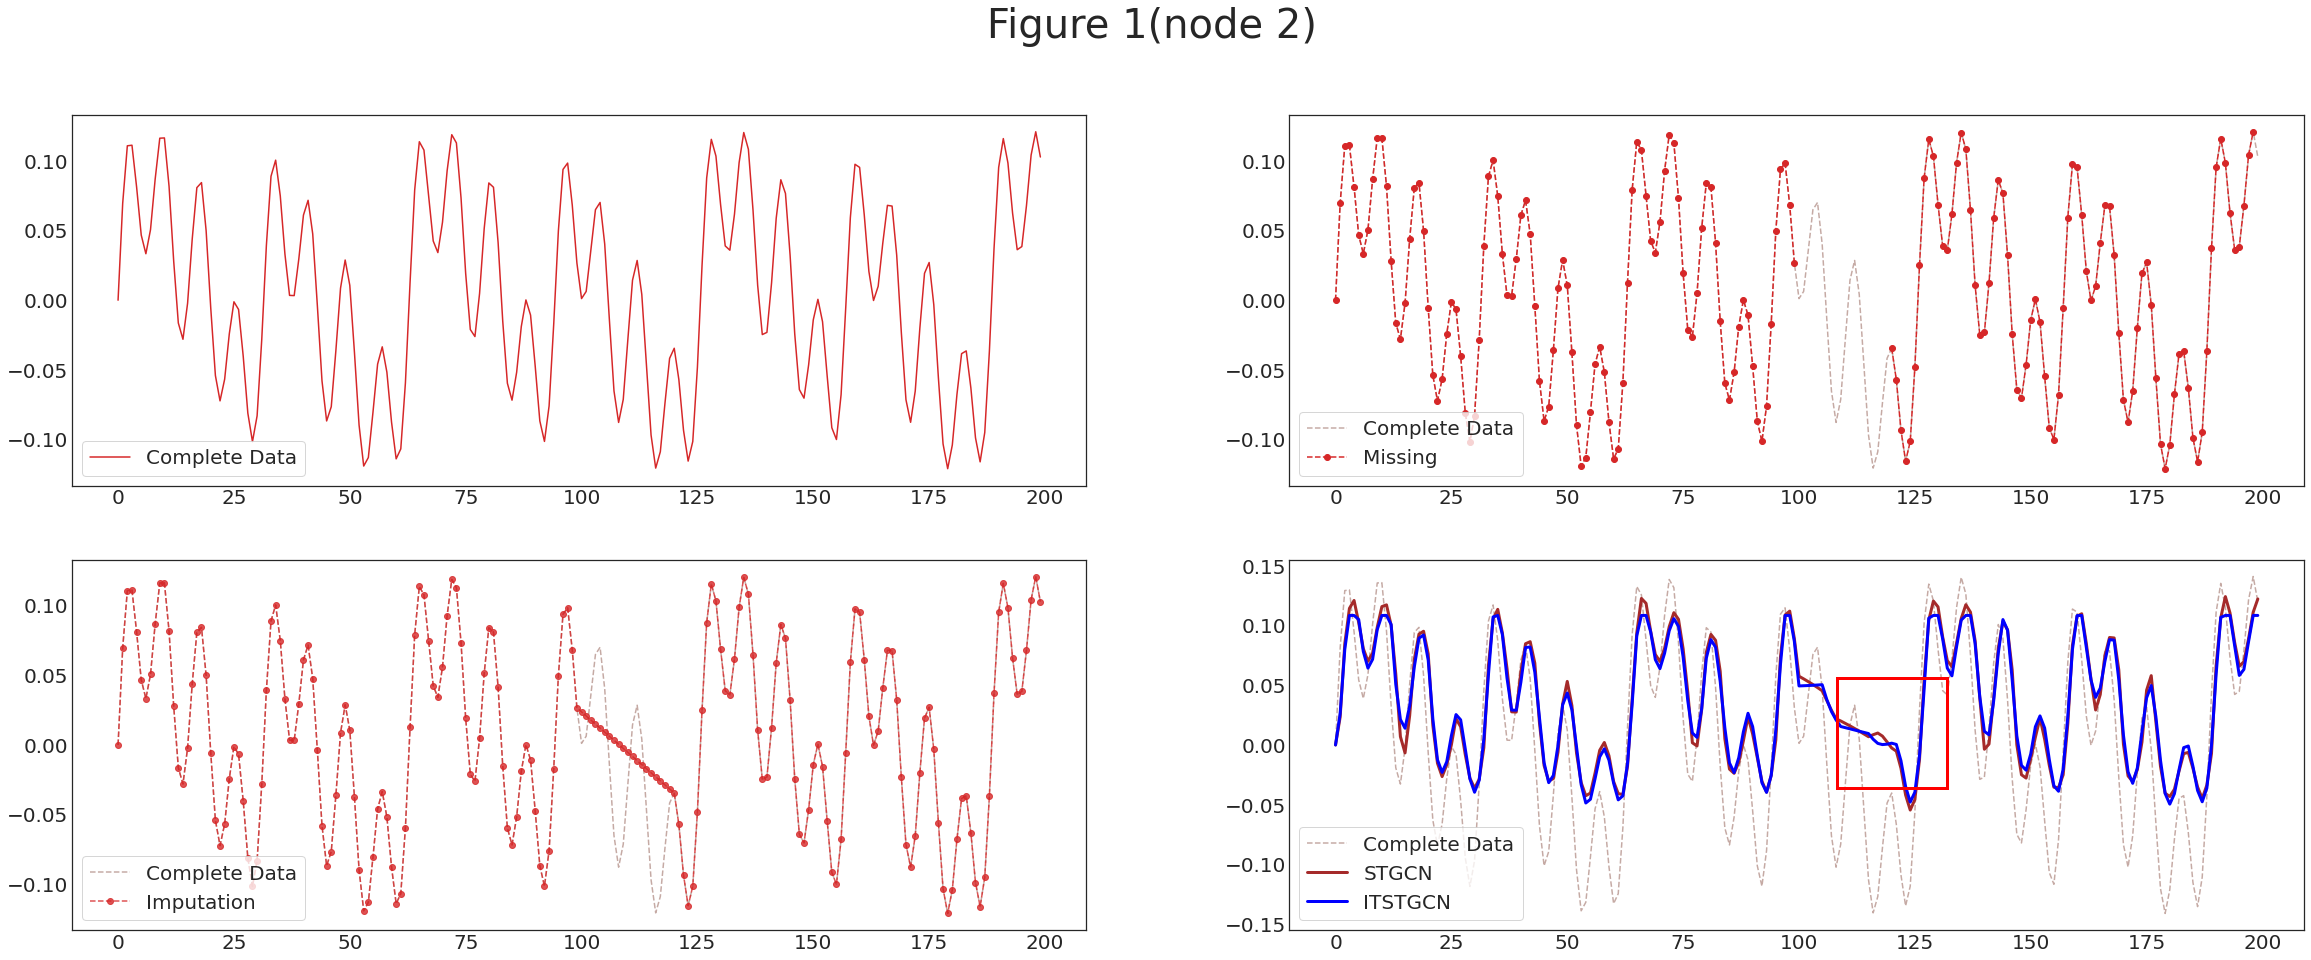

In [22]:
with plt.style.context('seaborn-white'):
    # plt.rcParams['font.family'] = 'xkcd'
    # plt.xkcd(scale=0,length=200)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(40,15))
    fig.suptitle('Figure 1(node 2)',fontsize=40)
    ax1.plot(df1['y'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax2.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.tensor(dataset_miss05031.features).reshape(-1,2)[:,1],'--o',color='C3',label='Missing')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax3.plot(df1['y'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor05032.f_tr[:,1],'--o',color='C3',alpha=0.8,label='Imputation')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    ax4.plot(df1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor05031.fhat_tr[:,1],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor05032.fhat_tr[:,1],color='blue',lw=3,label='ITSTGCN')
    ax4.plot(120, 0.01,'s', markersize=110, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

---

---

---

---

---

---

---

---

---

---

---

In [23]:
np.sum((np.array([1,2]) - np.array([[1],[2]]))**2)

2